In [0]:
# Copyright 2019 Google LLC.
#
# Licensed under the Apache License, Version 2.0 (the "License")

import tensorflow as tf
import numpy as np
from collections import namedtuple
import matplotlib.pyplot as plt
import random
import time
import collections
import seaborn as sns
import pickle
import tensorflow_probability as tfp
from tensorflow_probability.python.layers import util as tfp_layers_util

tf.enable_v2_tensorshape()

NeuralProcessParams = collections.namedtuple('NeuralProcessParams',
                                             ['dim_r', 'dim_z','dim_w',
                                              'n_hidden_units_r',
                                              'n_hidden_units_g'])
GaussianParams = collections.namedtuple('GaussianParams', ['mu', 'sigma'])
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [0]:
#choose the model here
exp_type = 'CNP' # choose from 'CNP', 'MR-CNP-A', 'MR-CNP-W'

noise_scale = 0.1 #@param {type:"number"}
n_obs = 20 #@param {type:"number"}
n_context = 10 #@param {type:"number"}
K_amp = 20 #@param {type:"number"}
x_width = 5 #@param {type:"number"}
learning_rate= 0.001 #@param {type:"number"}
n_iter = 30000 #@param {type:"number"}
amps = np.linspace(0.1,4,K_amp)
params = \
NeuralProcessParams(dim_r=10, dim_z=5, dim_w = 5,
                    n_hidden_units_r=[100,100],
                    n_hidden_units_g=[100,100]) 

In [0]:
# auxilliary functions

def split_context_target(xs, ys, n_context,
                         context_xs, context_ys, target_xs, target_ys):
  """
    split samples randomly into task training and task validation sets.
  """
  indices = set(range(ys.shape[0]))
  context_set_indices = set(random.sample(indices, n_context))
  target_set_indices = indices - context_set_indices

  return {
      context_xs: xs[list(context_set_indices), :],
      context_ys: ys[list(context_set_indices), :],
      target_xs: xs[list(target_set_indices), :],
      target_ys: ys[list(target_set_indices), :]
  }

def sampling(output):
  """
    sample from Gaussian Distribution
  """
  mu, logstd = tf.split(output, num_or_size_splits=2, axis=-1)
  sigma = tf.nn.softplus(logstd)
  ws = mu + tf.random_normal(tf.shape(mu)) * sigma
  return ws, mu, sigma

def merge(A, B):
  '''A is [n, k1], B is [m, k2], return [n, m, (k1+k2)]
  '''
  A_repeat = tf.expand_dims(A, axis=1)
  A_repeat = tf.tile(A_repeat, [1, tf.shape(B)[0], 1])

  B_repeat = tf.expand_dims(B, axis=0)
  B_repeat = tf.tile(B_repeat, [tf.shape(A)[0], 1, 1])

  return tf.concat([A_repeat, B_repeat], axis=2)

def kl_qp_gaussian(mu_q, sigma_q, mu_p, sigma_p):
  """KL(N(mu_q), Diag(sigma_q^2) || N(mu_p), Diag(sigma_p^2))"""
  sigma2_q = tf.square(sigma_q) + 1e-16
  sigma2_p = tf.square(sigma_p) + 1e-16
  temp = tf.log(sigma2_p) - tf.log(sigma2_q) - 1.0 + \
          sigma2_q / sigma2_p + tf.square(mu_q - mu_p) / sigma2_p  #N*D
  kl = 0.5 * tf.reduce_sum(temp, axis = 1)
  return tf.reduce_mean(kl)


In [0]:
# (MR-)CNP model

if exp_type == 'MR-CNP-W':
  kernel_posterior_fn=tfp_layers_util.default_mean_field_normal_fn(untransformed_scale_initializer=tf.compat.v1.initializers.random_normal(
    mean=-3., stddev=0.1))
  encoder_w = tf.keras.Sequential([
          tfp.layers.DenseReparameterization(100, activation=tf.nn.relu, kernel_posterior_fn = kernel_posterior_fn),
          tfp.layers.DenseReparameterization(params.dim_w),
        ])

if exp_type == 'MR-CNP-A':
  def encoder_w(xas, params):
    hidden_layer = xas
    hidden_layer = tf.layers.dense(hidden_layer, 100,
                                  activation=tf.nn.relu,
                                  name='encoder_w_{}'.format(0),
                                  reuse=tf.AUTO_REUSE,
                                  kernel_initializer='normal')
    # Last layer is simple linear
    mu_w = tf.layers.dense(hidden_layer, params.dim_w, name='w_params_mu',
                        reuse=tf.AUTO_REUSE, kernel_initializer='normal')

    sigma_w = tf.layers.dense(hidden_layer, params.dim_w, name='w_params_sigma',
                            reuse=tf.AUTO_REUSE,
                            kernel_initializer='normal')
    sigma_w = tf.nn.softplus(sigma_w)
    return mu_w, sigma_w

def encoder_r(xyas, params):
  """
    encode task training data.
  """
  hidden_layer = xyas
  for i, n_hidden_units in enumerate(params.n_hidden_units_r):
    hidden_layer = tf.layers.dense(hidden_layer, n_hidden_units,
                                   activation=tf.nn.relu,
                                   name='encoder_layer_{}'.format(i),
                                   reuse=tf.AUTO_REUSE,
                                   kernel_initializer='normal')

  # Last layer is linear
  i = len(params.n_hidden_units_r)
  r = tf.layers.dense(hidden_layer, params.dim_r,
                      name='encoder_layer_{}'.format(i),
                      reuse=tf.AUTO_REUSE,
                      kernel_initializer='normal')
  return r


def xy_to_z_params(xs, ys, amplitude, params, encoder_w=None):
  '''
    Aggregator of task training data.
    i) rs = T1(xas, ys); ii) r = mean(rs) iii)z = T2(r)
  '''
  # i)
  amplitude = tf.tile(amplitude, [tf.shape(xs)[0], 1])
  if exp_type == 'CNP':
    xyas = tf.concat([xs, ys, amplitude], axis=1)
    rs = encoder_r(xyas, params)

  if exp_type == 'MR-CNP-W':
    xas = tf.concat([xs, amplitude], axis=1)
    ws = encoder_w(xas)
    wys = tf.concat([ws, ys], axis=1)
    rs = encoder_r(wys, params)

  if exp_type == 'MR-CNP-A':
    xas = tf.concat([xs, amplitude], axis=1)
    mu_w,  sigma_w= encoder_w(xas, params)
    ws = mu_w + tf.random_normal(tf.shape(mu_w)) * sigma_w
    wys = tf.concat([ws, ys], axis=1)
    rs = encoder_r(wys, params)
  # ii)
  r = tf.reshape(tf.reduce_mean(rs, axis=0), [1, -1])
  # iii)
  z_sample = tf.layers.dense(r, params.dim_z, name='z_params_mu',
                      reuse=tf.AUTO_REUSE, kernel_initializer='normal')
  if exp_type == 'MR-CNP-A':
    return z_sample, mu_w, sigma_w
  else:
    return z_sample



def decoder_g(zws, params, activation = None):
  '''
    y_hat =  G(context, task testing input)
  '''
  hidden_layer = zws
  for i, n_hidden_units in enumerate(params.n_hidden_units_g):
    hidden_layer = tf.layers.dense(hidden_layer, n_hidden_units,
                                  activation=tf.nn.relu,
                                  name='decoder_layer_{}'.format(i),
                                  reuse=tf.AUTO_REUSE,
                                  kernel_initializer='normal')

  # Last layer is linear
  i = len(params.n_hidden_units_g)
  y_hat = tf.layers.dense(hidden_layer, 1,
                                name='decoder_layer_{}'.format(i),
                                reuse=tf.AUTO_REUSE,
                                kernel_initializer='normal')
  return y_hat

def neg_loglikelihood(y_star, mu_star, noise_scale=noise_scale):
  p_normal = tf.distributions.Normal(loc=mu_star, scale=noise_scale)
  loglike = p_normal.log_prob(y_star) #n_target * n_z
  loglike = tf.reduce_sum(loglike, axis=0)
  loglike = tf.reduce_mean(loglike)
  return -loglike




In [0]:
tf.reset_default_graph()

# Placeholders for training inputs
context_xs = tf.placeholder(tf.float32, (None, 1))
context_ys = tf.placeholder(tf.float32, (None, 1))
target_xs = tf.placeholder(tf.float32, (None, 1))
target_ys = tf.placeholder(tf.float32, (None, 1))
amplitude = tf.placeholder(tf.float32, (1, K_amp))
if exp_type == 'MR-CNP-W':
  Beta = tf.placeholder_with_default(0.15, ())
if exp_type == 'MR-CNP-A':
  Beta = tf.placeholder_with_default(5.0, ())

if exp_type == 'MR-CNP-A':
  z_samples, mu_w, sigma_w =  xy_to_z_params(context_xs, context_ys, amplitude, params, encoder_w)
else:
  z_samples =  xy_to_z_params(context_xs, context_ys, amplitude, params, encoder_w)

target_xas = tf.concat([target_xs, tf.tile(amplitude, [tf.shape(target_xs)[0], 1])], axis=1)

if exp_type == 'CNP':
  input_target = merge(z_samples, target_xas)

if exp_type == 'MR-CNP-W':
  with tf.variable_scope('encoder_w'):
    target_ws = encoder_w(target_xas)
  input_target = merge(z_samples, target_ws) #n_z * n_target * (d_z + d_w)

if exp_type == 'MR-CNP-A':
  target_mu_w, target_sigma_w = encoder_w(target_xas, params)
  target_ws = target_mu_w + tf.random_normal(tf.shape(target_mu_w)) * target_sigma_w
  input_target = merge(z_samples, target_ws) #n_z * n_target * (d_z + d_w)

# sample y_hat ~  y|(w,z)
y_star_mu_test = decoder_g(input_target, params)
y_star_mu_test = tf.squeeze(y_star_mu_test, axis=2)
y_star_mu_test = tf.transpose(y_star_mu_test)  #n_target * n_z


# loss & optimizer
neg_loglike = neg_loglikelihood(target_ys, y_star_mu_test)
if exp_type == 'CNP':
  loss = neg_loglike
if exp_type == 'MR-CNP-W':
  kl_loss = Beta * sum(encoder_w.losses)
  loss = neg_loglike + kl_loss

if exp_type == 'MR-CNP-A':
  kl_ib = kl_qp_gaussian(mu_w, sigma_w,
                        tf.zeros(tf.shape(mu_w)), tf.ones(tf.shape(mu_w)))
  loss = neg_loglike + Beta * kl_ib

optimizer = tf.train.AdamOptimizer(learning_rate)
train_op = optimizer.minimize(loss)


def train_model(sess, n_iter = n_iter, verbose = False):
  cost = []; cost_r = []
  for i in range(n_iter):
      #generate data
      xs = np.random.uniform(-x_width, x_width, n_obs)
      amp_ind = random.randint(0,K_amp-5)
      amp = np.zeros([1, K_amp]); amp[0,amp_ind] = 1
      ys = amps[amp_ind] * np.sin(xs) + np.random.normal(scale = noise_scale, size = xs.shape)
      feed_dict = split_context_target(xs.reshape(-1, 1), ys.reshape(-1, 1),
                                      n_context, context_xs, context_ys, target_xs, target_ys)
      feed_dict.update({amplitude:amp})

      #training
      A = sess.run((train_op, loss), feed_dict=feed_dict)
      cost.append(A[1])

      if verbose and i%5000 == 0:
        cost_r.append(np.mean(cost))
        print('iter=', i, "Loss: {:.3f}".format(np.mean(cost)))
        cost = []
  return sess




In [0]:
def plot_out(sess, amp_ind, n_context=n_context, amps = amps, width = x_width, ax = None, seed=None, K_test_sample=100, legend = False):
    if seed is not None:
      np.random.seed(seed**2)
    A = np.random.uniform(low = amps[0], high = amps[-1])
    a_onehot = np.zeros([1, K_amp]); a_onehot[0,amp_ind] = 1
    #task training
    xc_test = np.reshape(np.random.uniform(-width, width, n_context),[-1, 1])
    yc_test = A*np.sin(xc_test) + np.random.normal(scale = noise_scale, size = xc_test.shape)
    #task validation
    xs_test = np.reshape(np.linspace(-5, 5, 100),[-1, 1])
    ys_test = A*np.sin(xs_test)

    mean_curve = 0
    for i in range(K_test_sample):
      sample_curves = sess.run(y_star_mu_test, feed_dict = {context_xs:xc_test , context_ys:yc_test ,
                              target_xs:xs_test, target_ys:ys_test, amplitude:a_onehot})
      mean_curve += sample_curves[:,0] / (K_test_sample*1.0)
    error = np.mean(np.square(mean_curve - ys_test[:,0]))

    if ax is not None:
      plt.sca(ax)
      plt.plot(xs_test,ys_test,'-', color='darkorange', linewidth=2.0, label = 'True Function', zorder=2)
      plt.plot(xs_test,mean_curve,'b-', linewidth=2.0, label = 'Prediction', zorder=2)
      plt.ylim([-6,6])
      plt.axvline(x=-width, linestyle='--')
      plt.axvline(x=width,linestyle='--')
      plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
      plt.plot(xc_test,yc_test, '^',  label = 'Context Points', zorder=3)
      if legend:
        plt.legend( loc='center left', bbox_to_anchor=(1, 0.5))

    return error, A

#Training & Testing for CNP

In [0]:

sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess = train_model(sess, n_iter=n_iter, verbose=False)


print("Model is", exp_type)
n_test_task = 100
n_context_test = 5
errors = []
for i in range(n_test_task):
  error, A = plot_out(sess, amp_ind = random.randint(5,K_amp-5), n_context=n_context_test, seed = i)
  errors.append(error)
print("n_context = ", n_context_test, "error =", np.mean(errors))

n_context_test = 10
errors = []
for i in range(n_test_task):
  error, A = plot_out(sess, amp_ind = random.randint(5,K_amp-5), n_context=n_context_test, seed = i)
  errors.append(error)
print("n_context = ", n_context_test, "error =", np.mean(errors))


Model is CNP
n_context =  5 error = 0.9669236715483034
n_context =  10 error = 0.8186722369121264


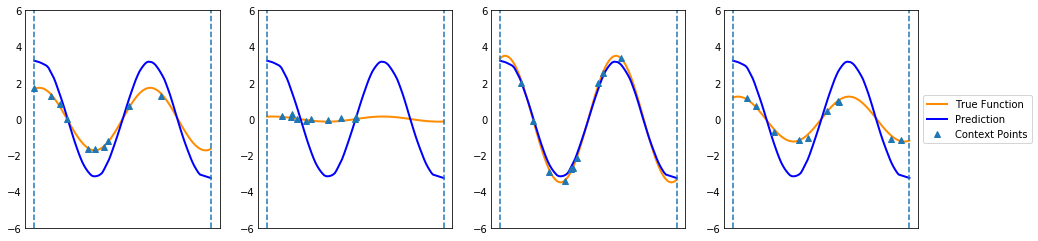

In [0]:
fig, ax = plt.subplots(ncols=4, figsize=(16,4))
a_onehot = 15
error, A = plot_out(sess, a_onehot, seed = 1,  ax = ax[0]);
error, A  = plot_out(sess, a_onehot, seed = 3,  ax = ax[1]);
error, A = plot_out(sess, a_onehot, seed = 5,  ax = ax[2]);
error, A = plot_out(sess, a_onehot,  seed = 15,  ax = ax[3], legend='True');
for ax_i in ax:
    ax_i.tick_params(axis='both', which='major',length=0)

#Training & Testing for MR-CNP(A)



In [0]:

sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess = train_model(sess, n_iter=n_iter, verbose=False)


print("Model is", exp_type)
n_test_task = 100
n_context_test = 5
errors = []
for i in range(n_test_task):
  error, A = plot_out(sess, amp_ind = random.randint(5,K_amp-5), n_context=n_context_test, seed = i)
  errors.append(error)
print("n_context = ", n_context_test, "error =", np.mean(errors))

n_context_test = 10
errors = []
for i in range(n_test_task):
  error, A = plot_out(sess, amp_ind = random.randint(5,K_amp-5), n_context=n_context_test, seed = i)
  errors.append(error)
print("n_context = ", n_context_test, "error =", np.mean(errors))

Model is MR-CNP-A
n_context =  5 error = 0.04330778675580867
n_context =  10 error = 0.03515166627173694


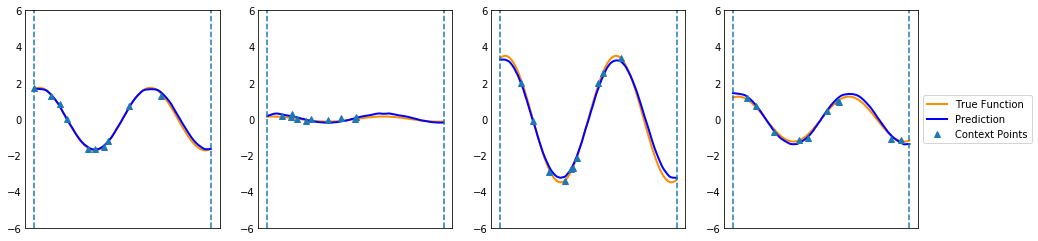

In [0]:
fig, ax = plt.subplots(ncols=4, figsize=(16,4))
a_onehot = 15
error, A = plot_out(sess, a_onehot, seed = 1,  ax = ax[0]);
error, A  = plot_out(sess, a_onehot, seed = 3,  ax = ax[1]);
error, A = plot_out(sess, a_onehot, seed = 5,  ax = ax[2]);
error, A = plot_out(sess, a_onehot,  seed = 15,  ax = ax[3], legend='True');
for ax_i in ax:
    ax_i.tick_params(axis='both', which='major',length=0)

#Training & Testing for MR-CNP(W)

In [0]:
n_iter = 120000
sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess = train_model(sess, n_iter=n_iter, verbose=False)


print("Model is", exp_type)
n_test_task = 100
n_context_test = 5
errors = []
for i in range(n_test_task):
  error, A = plot_out(sess, amp_ind = random.randint(5,K_amp-5), n_context=n_context_test, seed = i)
  errors.append(error)
print("n_context = ", n_context_test, "error =", np.mean(errors))

n_context_test = 10
errors = []
for i in range(n_test_task):
  error, A = plot_out(sess, amp_ind = random.randint(5,K_amp-5), n_context=n_context_test, seed = i)
  errors.append(error)
print("n_context = ", n_context_test, "error =", np.mean(errors))

Model is MR-CNP-W
n_context =  5 error = 0.06632440420899471
n_context =  10 error = 0.05497082944476869


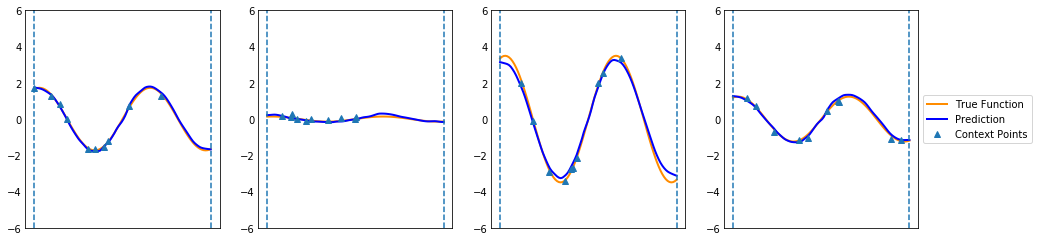

In [0]:
fig, ax = plt.subplots(ncols=4, figsize=(16,4))
a_onehot = 15
error, A = plot_out(sess, a_onehot, seed = 1,  ax = ax[0]);
error, A  = plot_out(sess, a_onehot, seed = 3,  ax = ax[1]);
error, A = plot_out(sess, a_onehot, seed = 5,  ax = ax[2]);
error, A = plot_out(sess, a_onehot,  seed = 15,  ax = ax[3], legend='True');
for ax_i in ax:
    ax_i.tick_params(axis='both', which='major',length=0)